# Movie similarity function

Instructions:

1. pip install -r requirements.txt

2. to run the app, cd into the unzipped folder, and run python app.py

3. browse to http://localhost:105/Batman/, and form there you can change the movie title

4. run/inspect the notebook

The Gist of the algo is to embed the plots and the titles, and use their combined embeddings to retrieve the nearest neighbors of each
given query movie. Then, the recommendations that do not match the metadata (genre, year, language, country, length) are dropped. The top remainder reocmmendations are returned. See details in the notebook.

In [3]:
! pip install -r requirements.txt

In [4]:
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from typing import Iterable, List, Set, Dict, Tuple
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from flask import Flask
from flask import jsonify
import os
import re
# from itables import init_notebook_mode, show
from collections import defaultdict
from sklearn.decomposition import PCA
import pickle

C:\Users\amnon\anaconda3\envs\main\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data, initial exploration

In [5]:
train_path = 'train.json'

In [6]:
df = pd.read_json(train_path, lines=True)
df.head()

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
0,{'/m/07c9s': 'Tamil Language'},{'/m/07s9rl0': 'Drama'},Periya Idathu Penn,1963,{'/m/03rk0': 'India'},,Murugappa is a small time farm labourer who l...,
1,{'/m/02h40lc': 'English Language'},"{'/m/01jfsb': 'Thriller', '/m/02n4kr': 'Myster...",The Flock,2007,{'/m/09c7w0': 'United States of America'},,A hyper-vigilant agent of the Department of Pu...,96.0
2,{'/m/03k50': 'Hindi Language'},"{'/m/02kdv5l': 'Action', '/m/07s9rl0': 'Drama'}",Gang,2000-04-14,{'/m/03rk0': 'India'},,"Four friends- Gangu , Abdul , Nihal and Gary ...",
3,"{'/m/07qv_': 'Tagalog language', '/m/01jb8r': ...","{'/m/0hn10': 'LGBT', '/m/07s9rl0': 'Drama', '/...",Daybreak,2008-02-20,{'/m/05v8c': 'Philippines'},,A married man is having an affair with another...,85.0
4,{'/m/02h40lc': 'English Language'},"{'/m/06cvj': 'Romantic comedy', '/m/02l7c8': '...",Tomboy,1985-01-25,{'/m/09c7w0': 'United States of America'},14100000,"The movie concerns the life of Tomasina ""Tommy...",91.0


In [7]:
df.describe()

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
count,29922,29922,29922,29922,29922,29922,30000,29922
unique,1065,12691,28703,10661,1156,4835,29992,376
top,{'/m/02h40lc': 'English Language'},{'/m/07s9rl0': 'Drama'},I Love You,,{'/m/09c7w0': 'United States of America'},,A woman is thrown out of her home by her jealo...,
freq,14631,1882,7,1861,12571,24543,5,4667


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   languages                 29922 non-null  object
 1   genres                    29922 non-null  object
 2   title                     29922 non-null  object
 3   release_date              29922 non-null  object
 4   countries                 29922 non-null  object
 5   movie_box_office_revenue  29922 non-null  object
 6   plot_summary              30000 non-null  object
 7   feature_length            29922 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB


## Shuffle the data, it's useful for a few sampling operations later on

In [9]:
df = df.sample(frac=1.0, random_state=7)

#  Clean Data

## Language

See that there are many NaNs

In [10]:
df.languages[df.languages.isna()]

24448    NaN
17502    NaN
24146    NaN
13789    NaN
3343     NaN
        ... 
15941    NaN
1590     NaN
12953    NaN
17237    NaN
17954    NaN
Name: languages, Length: 78, dtype: object

In [11]:
def clean_tags(d: dict):
    """
    clean up tag columns like langauges, genres and countires
    """
    if pd.isna(d):
        return []
    return [re.sub(r' language| films?| movies?', '', s, flags=re.IGNORECASE) for s in d.values()]

In [12]:
df['languages'] = df.languages.map(clean_tags)

In [13]:
df.head()

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
1252,[Bengali],"{'/m/01jfsb': 'Thriller', '/m/02n4kr': 'Mystery'}",Chiriyakhana,1967,{'/m/03rk0': 'India'},,"The story revolves around a retired judge, Mr....",125.0
10444,[Telugu],"{'/m/02l7c8': 'Romance Film', '/m/03q4nz': 'Wo...",Samba,2004-06-09,{'/m/03rk0': 'India'},,Dharmayya Naidu a underworld kingpin who lost...,145.0
8994,[English],{'/m/0hfjk': 'Western'},Born Reckless,1958-11,{'/m/09c7w0': 'United States of America'},,Kelly Cobb travels and performs in various cou...,80.0
7463,"[French, Polish, English]","{'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D...",Story of O,1975-08-26,"{'/m/0f8l9c': 'France', '/m/0d060g': 'Canada',...",,A young woman fashion photographer known only ...,105.0
1910,[Tamil],{'/m/07s9rl0': 'Drama'},Needhikku Thalaivanangu,1976-03-18,{'/m/03rk0': 'India'},,MGR acted as a college student who is very muc...,


In [14]:
language_counter = Counter()
df.languages.map(language_counter.update)
language_counter

Counter({'Bengali': 180,
         'Telugu': 473,
         'English': 17588,
         'French': 1388,
         'Polish': 96,
         'Tamil': 795,
         'Silent': 623,
         'Spanish': 1033,
         'Portuguese': 137,
         'Punjabi': 65,
         'Bulgarian': 23,
         'Italian': 700,
         'Uzbek': 6,
         'Russian': 451,
         'Cantonese': 428,
         'Korean': 464,
         'Japanese': 914,
         'Standard Mandarin': 550,
         'Finnish': 60,
         'Ukrainian': 22,
         'Malayalam': 547,
         'Hindi': 1581,
         'Chinese': 55,
         'German': 719,
         'Belarusian': 3,
         'Quechua': 6,
         'Marathi': 32,
         'Xhosa': 11,
         'Chechen': 2,
         'Turkish': 87,
         'Swedish': 152,
         'Icelandic': 23,
         'Albanian': 17,
         'Macedonian': 8,
         'Thai': 129,
         'Tagalog': 161,
         'Standard Cantonese': 249,
         'Czech': 72,
         'Urdu': 166,
         'American Eng

In [15]:
wc = WordCloud(max_words=1000, margin=10,
               random_state=1).generate(' '.join(df.languages.map(' '.join).values))

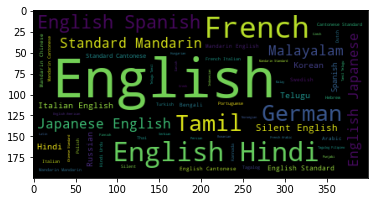

In [16]:
plt.imshow(wc)

TBD

Seems like the language tags are too specific, and we would benefit from merging all variants of English together, as well as Arabic, Portuguese, Mandarin, etc.

## Genres

See that there are many NaNs

In [17]:
df.genres[df.genres.isna()]

24448    NaN
17502    NaN
24146    NaN
13789    NaN
3343     NaN
        ... 
15941    NaN
1590     NaN
12953    NaN
17237    NaN
17954    NaN
Name: genres, Length: 78, dtype: object

In [18]:
df['genres'] = df.genres.map(clean_tags)

In [19]:
genres_counter = Counter()
df.genres.map(genres_counter.update)
genres_counter

Counter({'Thriller': 4594,
         'Mystery': 1487,
         'Romance': 4738,
         'World cinema': 3629,
         'Western': 740,
         'Drama': 13547,
         'LGBT': 595,
         'Erotic Drama': 81,
         'Horror': 2867,
         'Erotica': 170,
         'Cult': 464,
         'Erotic thriller': 122,
         'Comedy': 8736,
         'Short': 2282,
         'Animation': 1722,
         'Action': 4137,
         'Crime Fiction': 3046,
         'War': 1087,
         'Detective fiction': 161,
         'Detective': 203,
         'Supernatural': 400,
         'Psychological thriller': 797,
         'Crime Thriller': 1203,
         'Family': 2265,
         'Teen': 593,
         "Children's/Family": 542,
         'Documentary': 851,
         'Romantic comedy': 1494,
         'Indie': 2627,
         'Family Drama': 540,
         'Comedy-drama': 874,
         'Gay': 157,
         'Film adaptation': 858,
         'Gay Interest': 156,
         'Gay Themed': 191,
         'Romantic dra

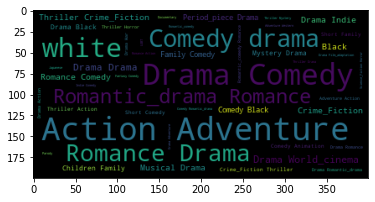

In [20]:
wc = WordCloud(max_words=1000, margin=10,
               random_state=1).generate(' '.join(df.genres.map(lambda l: ' '.join(s.replace(' ', '_') for s in l)).values))
plt.imshow(wc)

## Countries

See that there are many NaNs

In [21]:
df.countries[df.countries.isna()]

24448    NaN
17502    NaN
24146    NaN
13789    NaN
3343     NaN
        ... 
15941    NaN
1590     NaN
12953    NaN
17237    NaN
17954    NaN
Name: countries, Length: 78, dtype: object

In [22]:
df['countries'] = df.countries.map(clean_tags)

In [23]:
countries_counter = Counter()
df.countries.map(countries_counter.update)
countries_counter

Counter({'India': 3371,
         'United States of America': 14700,
         'France': 1607,
         'Canada': 1061,
         'Germany': 940,
         'United Kingdom': 2881,
         'Spain': 468,
         'Brazil': 91,
         'Bulgaria': 31,
         'Australia': 525,
         'New Zealand': 177,
         'Italy': 875,
         'Uzbek SSR': 5,
         'South Korea': 531,
         'Japan': 1011,
         'Netherlands': 165,
         'Hong Kong': 562,
         'China': 277,
         'Finland': 74,
         'Soviet Union': 182,
         'Russia': 157,
         'Mexico': 193,
         'Argentina': 174,
         'German Democratic Republic': 44,
         'Ireland': 127,
         'South Africa': 97,
         'Sweden': 187,
         'Norway': 72,
         'Iceland': 24,
         'Albania': 5,
         'Thailand': 125,
         'Bangladesh': 16,
         'Czechoslovakia': 36,
         'Turkey': 95,
         'Bosnia and Herzegovina': 13,
         'Iran': 68,
         'Poland': 97,
       

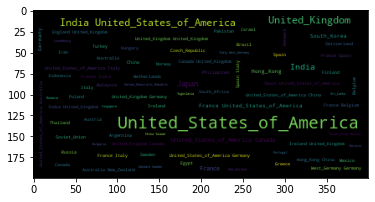

In [24]:
wc = WordCloud(max_words=1000, margin=10,
               random_state=1).generate(' '.join(df.countries.map(lambda l: ' '.join(s.replace(' ', '_') for s in l)).values))

plt.imshow(wc)

## Plot

assure there are no nulls

In [25]:
df.plot_summary.isna().sum()

0

A brief skimming leads me to believe that all or nearly all plots are written in English. If not, we can use a third party language detector to treat the non English texts.

In [26]:
df.plot_summary.sample(10, random_state=7).values

array(['Chicago socialite Cynthia Drexel arranges for New York City opera star Anthony Allen to sing at a private party for a $15,000 fee but, tired of his arduous performance schedule and the silly promotional stunts devised by his agent Petroff, he flees to his hometown in New Mexico, then his secluded cabin in the Sierra Madres. Determined to make him fulfill his commitment, Cynthia pursues him in her private plane, but he refuses to return with her, despite the efforts of her Uncle Bob and his valet Botts to convince him otherwise. When Cynthia leaves without her suitcase, a now intrigued Anthony returns to Chicago with her belongings. When he arrives at her home, an angry Cynthia criticizes his singing and tells him she has no romantic interest in him as she is engaged Count Raul Du Rienne. Cynthia sues him for breach of contract, but in court Anthony argues he refused to sing for her because she does not appreciate his talent, and the case is dismissed. Outside the courtroom, Unc

## title

See there are a few nulls to replace

In [27]:
df.title.isna().sum()

78

In [28]:
df.title.fillna('', inplace=True)

In [29]:
df.title.isna().sum()

0

See there are duplicate titles, which could mess things up when we later query by title

In [30]:
vc = df.title.value_counts() 
vc[vc>1]

                       78
I Love You              7
Alice in Wonderland     6
The Hole                6
Wanted                  6
                       ..
Joshua                  2
American Gothic         2
Silk                    2
Staying Alive           2
Thursday's Child        2
Name: title, Length: 1028, dtype: int64

See for example the different movies called "Wanted"

In [31]:
df[df.title == 'Wanted']

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length
18829,[Bengali],[Action],Wanted,2010-04-30,[India],,Rajkumar Banerjee /Raja ([[Jeet is a professi...,164.0
8395,[English],"[Crime Fiction, Action Thrillers, Fantasy Adve...",Wanted,2008-06-12,"[United States of America, Germany]",341433252,"In Chicago, Wesley Gibson is an American born...",110.0
709,[Hindi],"[Thriller, Action/Adventure, World cinema, Act...",Wanted,2009-09-18,[India],,"The story is about Radhe , a hardcore gangster...",153.0
1124,[],"[Crime Fiction, Thriller, Drama]",Wanted,2005,[],,"The show follows an elite taskforce, with memb...",
5472,[Italian],"[Romance, Action, Drama, Western]",Wanted,1967-03-22,[Italy],,A local sheriff is unjustly accused of murder...,107.0
12365,[],"[Crime Fiction, Thriller, Action, Bollywood]",Wanted,,[India],,Five college friends badly in need of money ki...,


So, if a user queries for an ambiguous title ("Wanted"), we treat it as if she queries for each individual "Wanted" film separately, and return all 6 sets of recommendations.

We do this translation by maintaining a map from each title to all of its entries

In [32]:
title2indices = defaultdict(lambda: [])
df.apply(lambda row: title2indices[row.title].append(row.name), axis=1)
title2indices = dict(title2indices) # make it a regular dict, that can be pickled

In [33]:
title2indices['Wanted']

[18829, 8395, 709, 1124, 5472, 12365]

## release_date

### Observe:

In [34]:
df.release_date

1252           1967
10444    2004-06-09
8994        1958-11
7463     1975-08-26
1910     1976-03-18
            ...    
5699     2011-07-29
10742    2009-07-24
16921          1944
25796    2009-04-10
28847    1935-02-23
Name: release_date, Length: 30000, dtype: object

### Fill NAs

In [35]:
df.release_date.isna().sum()

78

In [36]:
df.release_date.fillna('', inplace=True)

In [37]:
df.release_date.isna().sum()

0

we want to extract the year, and print it in the film's display name, and also use it in the metadata match rules below

In [38]:
def extract_year(date: str) -> str:
    m = re.match(r'\d\d\d\d', date)
    if m is None:
        return ''
    return int(m.group(0))

df['year'] = df.release_date.map(extract_year)

In [39]:
df.year

1252     1967
10444    2004
8994     1958
7463     1975
1910     1976
         ... 
5699     2011
10742    2009
16921    1944
25796    2009
28847    1935
Name: year, Length: 30000, dtype: object

notice there is a small amount of irregular release dates that we did not parse (<10%), and we will address then in future work

In [40]:
df[(df.year == '')].release_date

18124     
19686     
29697     
21758     
622       
        ..
6748      
11180     
16641     
28962     
27354     
Name: release_date, Length: 1939, dtype: object

## feature_length

we want the feture lengths to be  numbers, to compare them to e/o

In [41]:
df['feature_length'] = df.feature_length.map(lambda x: x if not x else float(x))

# Embed columns

## useful funcs

In [42]:
BATCH_SZ = 300 # my GPU can't handle much more than this sz

In [43]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [44]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [45]:
# Load model from HuggingFace Hub
english_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
english_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device)

In [46]:
def embed_batch(texts: List[str], model=english_model, tokenizer=english_tokenizer) -> torch.Tensor:
    # Clear GPU memory, sometimes helps
    # gc.collect()
    # torch.cuda.empty_cache()

    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    encoded_input.to(device)
    
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    return sentence_embeddings

def embed(texts: List[str], batch_sz: int = BATCH_SZ, model=english_model, tokenizer=english_tokenizer) -> torch.Tensor:
    embedding_batches = []
    for batch_start in range(0, len(texts), batch_sz):
        batched_texts = texts[batch_start: batch_start+batch_sz]
    
        embedding_batches.append(embed_batch(batched_texts, model=model, tokenizer=tokenizer))
        
    return torch.cat(embedding_batches).cpu()

In [47]:
def embed_column(vecs_path: str, column:str, model=english_model, tokenizer=english_tokenizer) -> torch.Tensor:
    """
    embed, while caching embeddings on file
    """
    if os.path.exists(vecs_path):
        vecs = torch.load(vecs_path)
    else:
        texts = df[column].to_list()
        print(f'embedding {len(texts)} {column} texts...')
        vecs = embed(texts, model=model, tokenizer=tokenizer)
        torch.save(vecs, vecs_path)        
    return vecs

##  embed plot

In [48]:
%%time
plot_vecs = embed_column('plot_vecs.pt', 'plot_summary', english_model, english_tokenizer)
plot_vecs.shape

CPU times: total: 78.1 ms
Wall time: 23.9 ms


torch.Size([30000, 384])

## Embed titles

Load model from HuggingFace Hub - a multilingual model that works on (probably) all title languages, but is weaker than the English models

In [49]:
multi_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
multi_model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2').to(device)

Downloading: 100%|██████████████████████████████████████████████████████████████████| 449M/449M [03:10<00:00, 2.47MB/s]


In [50]:
%%time
title_vecs = embed_column('title_vecs.pt', 'title', multi_model, multi_tokenizer)
title_vecs.shape

CPU times: total: 359 ms
Wall time: 57.4 ms


torch.Size([30000, 384])

## Embed the taggy columns (languages, genres, countries)

I tried embedding these columns and combining them with the plot and title columns, but the results were worse than without the taggy columns. 

Also, in principle, it's unclear if these 3 columns should contirbute more as embeddings, than as hard criteria.

So, in this final draft I use these columns only in simple filter rules - see below.

# Combine all embeddings into a single movie embedding

I tested this approach of "weighted average of embeddings of different fields", but it performed relatievely poor, so these next blocks are commented out

## Concatenate the plot embeddings with a reduced version of the title embeddings, 

We reduce dimensionality of the titles (to 50) for speed and performance gains, as well as weighting their relative importance to the plot. 

Future work: tune this magic number (50) against a labelled dataset of movie similarities.

FYI I tested UMAP and PCA, and PCA gave more stable results and fast runtime. Future work: investigate into UMAP to learn why this is.

In [51]:
%%time
title_vecs_d50 = PCA(50, copy=False, random_state=7).fit_transform(title_vecs)
title_vecs_d50.shape

CPU times: total: 5.17 s
Wall time: 538 ms


(30000, 50)

Normalize

In [52]:
np.linalg.norm(title_vecs_d50, axis=1)

array([0.68486306, 0.60342383, 0.66650977, ..., 0.81209161, 0.59247032,
       0.75792858])

In [53]:
title_vecs_d50 = F.normalize(torch.Tensor(title_vecs_d50))

In [54]:
np.linalg.norm(title_vecs_d50, axis=1)

array([1.       , 0.9999999, 1.       , ..., 1.       , 1.       ,
       1.       ], dtype=float32)

In [55]:
torch.save(title_vecs_d50, 'title_vecs_d50.pt')

## concate the metadata vecs with the plot vecs, and normalize

In [56]:
combined_vecs = torch.cat([plot_vecs, title_vecs_d50], dim=1)
combined_vecs = F.normalize(combined_vecs)
combined_vecs.shape

torch.Size([30000, 434])

## save combined vecs

In [57]:
torch.save(combined_vecs, 'combined_vecs.pt')

# create display names

In [58]:
df['display'] = df.apply(lambda row: f'{row.title} ({"/".join(row.countries)}, {row.year})', axis=1)

In [72]:
df.display

1252                           Chiriyakhana (India, 1967)
10444                                 Samba (India, 2004)
8994       Born Reckless (United States of America, 1958)
7463             Story of O (France/Canada/Germany, 1975)
1910                Needhikku Thalaivanangu (India, 1976)
                               ...                       
5699                                   Khap (India, 2011)
10742     The Answer Man (United States of America, 2009)
16921     Bathing Beauty (United States of America, 1944)
25796                       Pal Pal Dil Ke Ssaat (, 2009)
28847    Beginner's Luck (United States of America, 1935)
Name: display, Length: 30000, dtype: object

# Define the similarity function

## in order to lookup movie properties slim and fast, replace the pandas dataframe with a dict

In [60]:
df['genres'] = df.genres.map(set)
df['countries'] = df.countries.map(set)
df['languages'] = df.languages.map(set)

In [61]:
df.head()

,languages,genres,title,release_date,countries,movie_box_office_revenue,plot_summary,feature_length,year,display
1252,{Bengali},"{Thriller, Mystery}",Chiriyakhana,1967,{India},,"The story revolves around a retired judge, Mr....",125.0,1967,"Chiriyakhana (India, 1967)"
10444,{Telugu},"{World cinema, Romance}",Samba,2004-06-09,{India},,Dharmayya Naidu a underworld kingpin who lost...,145.0,2004,"Samba (India, 2004)"
8994,{English},{Western},Born Reckless,1958-11,{United States of America},,Kelly Cobb travels and performs in various cou...,80.0,1958,"Born Reckless (United States of America, 1958)"
7463,"{Polish, English, French}","{World cinema, Drama, Romance}",Story of O,1975-08-26,"{Canada, Germany, France}",,A young woman fashion photographer known only ...,105.0,1975,"Story of O (France/Canada/Germany, 1975)"
1910,{Tamil},{Drama},Needhikku Thalaivanangu,1976-03-18,{India},,MGR acted as a college student who is very muc...,,1976,"Needhikku Thalaivanangu (India, 1976)"


In [86]:
from collections import namedtuple
namedtuple({1:2, 3:4})

TypeError: namedtuple() missing 1 required positional argument: 'field_names'

In [111]:
index2metadata = df[['genres', 'languages', 'countries', 'year', 'feature_length', 'display']].to_dict('index')
# MovieProps = namedtuple('MovieProps', ['genres', 'languages', 'countries', 'year', 'feature_length', 'display'])
# index2metadata = df.apply(lambda row: MovieProps(row.genres, row.languages, row.countries, row.year, row.feature_length, row.display), axis=1).to_dict()
index2metadata[1252]

{'genres': {'Mystery', 'Thriller'},
 'languages': {'Bengali'},
 'countries': {'India'},
 'year': 1967,
 'feature_length': 125.0,
 'display': 'Chiriyakhana (India, 1967)'}

In [99]:
index2metadata[1252].year

1967

## The actual func

In [117]:
def get_similar_movies(movie_ndx: int, num_recommendations: int=3) -> List[str]:
    """
    get (an index to) a movie, and return (the display names of) its #{num_recommendations} most similar movies, by content.
    
    First, use dot product similarity (equivalent to cosine) to retrieve the movie's nearest neighbors among the combined_vecs.
    
    Second, filter the results according to metadata: each recommendation must have a matching genre, language and country, so that we Batman in English doesn't
    get "Batman XXX: a porn Parody", nor a Batman movie in Hindi, nor a Batman movie from India. 
    Each recommendation must also be release with 30y of the query movie,
    in order not to jump between eras, e.g., Batman of 1966 is not like the Batman of the 2000s.
    Finally, the recommendtion feature length must be within 10x of the query movie's length, in order not to mix shorts with feature films, (not sure about this).    
    
    Future work: need to fine tune these criteria, ideally flex them as much as possible so as not to overfit. 
    """
    # 1. get most similar movie indices, by dot product (cosine) similarity
    vec = combined_vecs[movie_ndx]
    similarities = np.inner(vec, combined_vecs)
    top_indices = list(reversed(np.argsort(similarities)))[1:] # remove #1 most similar, b/c it's (probably) the original title

    # 2. filter the recommendations by matching the metadata 
    top_similar_display_names = []
    query_movie = index2metadata[movie_ndx]
    genres = query_movie['genres']
    countries = query_movie['countries']
    languages = query_movie['languages']
    year = query_movie['year']
    feature_length = query_movie['feature_length']
    i = 0
    while (len(top_similar_display_names) < num_recommendations) and (i < len(top_indices)):
        recommendation = index2metadata[top_indices[i]]
        recom_genres = recommendation['genres']
        recom_countries = recommendation['countries']
        recom_langugaes = recommendation['languages']
        recom_year = recommendation['year']
        recom_feature_length = recommendation['feature_length']
                
        if (   ((not genres) or (not recom_genres) or set.intersection(genres, recom_genres))
           and ((not languages) or (not recom_langugaes) or set.intersection(languages, recom_langugaes))
           and ((not countries) or (not recom_countries) or set.intersection(countries, recom_countries))
           and ((not year) or (not recom_year) or (abs(year - recom_year) <= 30))
           and ((not feature_length) or (not recom_feature_length) or (0.1 < (feature_length / recom_feature_length) < 10))
           ):
            top_similar_display_names.append(recommendation['display'])
        i += 1
    
    return top_similar_display_names

## sanity tests:

In [118]:
num_recommendations=10
title = "Bambi"
i = title2indices[title][0]
print(df.loc[i].display)
get_similar_movies(i, num_recommendations)

Bambi (United States of America, 1942)


['Shenandoah (United States of America, 1965)',
 'Mogambo (United States of America, 1953)',
 'Baboo Band Baaja (, )',
 'Little Black Sambo (, 1935)',
 'Jungle Jingles (, 1929)',
 'The Legend of Lobo (United States of America, 1962)',
 'Jam (, )',
 'Gee Whiz-z-z-z-z-z-z (United States of America, 1956)',
 'Ebbie (United States of America/Canada, )',
 'Jungle Book (United States of America, 1942)']

In [119]:
num_recommendations=10
title = "Batman"
i = title2indices[title][0]
print(df.loc[i].display)
get_similar_movies(i, num_recommendations)

Batman (United States of America, 1966)


['Batman (United States of America/United Kingdom, 1989)',
 'Batman Returns (United States of America/United Kingdom, 1992)',
 'Adventures of Captain Marvel (United States of America, 1941)',
 'Predator (United States of America, 1987)',
 'Predator 2 (United States of America, 1990)',
 'The Trial of the Incredible Hulk (United States of America, 1989)',
 'Sniper (United States of America, 1993)',
 'Deadly Heroes (United States of America, )',
 'Hero at Large (United States of America, 1980)',
 'Dracula: Dead and Loving It (France/United States of America, 1995)']

In [120]:
num_recommendations=10
title = "The Jungle Book"
i = title2indices[title][0]
print(df.loc[i].display)
get_similar_movies(i, num_recommendations)

The Jungle Book (United States of America, 1994)


['The Jungle Book (United States of America, 1967)',
 'The Second Jungle Book: Mowgli & Baloo (, 1997)',
 'Jungle 2 Jungle (United States of America/France, 1997)',
 'FernGully: The Last Rainforest (United States of America/Australia, 1992)',
 'The Hidden Jungle (United States of America, 1990)',
 'George of the Jungle 2 (United States of America/Australia, 2003)',
 'George of the Jungle (United States of America, 1997)',
 'Once Upon a Forest (United States of America/United Kingdom, 1993)',
 'Tarzan (United States of America, 1999)',
 'FernGully 2: The Magical Rescue (United States of America, 1998)']

In [121]:
num_recommendations=10
title = "Rambo"
i = title2indices[title][0]
print(df.loc[i].display)
get_similar_movies(i, num_recommendations)

Rambo (United States of America/Germany, 2008)


['Rambo III (United States of America, 1988)',
 'Rambo: First Blood Part II (United States of America, 1985)',
 'Anaconda (United States of America/Brazil/Peru, 1997)',
 'Pig Hunt (United States of America, 2008)',
 'Delta Farce (United States of America, 2007)',
 'Malibu Shark Attack (, 2009)',
 'Vazhakku Enn 18/9 (, 2011)',
 'Bushwhacked (United States of America, 1995)',
 'Riverbend (United States of America, 1990)',
 'Jayeebhava (, )']

In [122]:
num_recommendations=10
title = "Toy Story"
i = title2indices[title][0]
print(df.loc[i].display)
get_similar_movies(i, num_recommendations)

Toy Story (United States of America, 1995)


['Toys (United States of America, 1992)',
 'The Toy (United States of America, 1982)',
 'Little Monsters (United States of America, 1989)',
 'Babes in Toyland (United States of America, 1999)',
 'Barbie in the Nutcracker (United States of America, 2001)',
 'Ah-sweet Mouse-story of Life (United States of America, )',
 'Lego: The Adventures of Clutch Powers (United States of America, 2010)',
 "Bugs Bunny's Christmas Carol (United States of America, 1979)",
 'Barbie: A Fairy Secret (, 2011)',
 'Mazes and Monsters (United States of America, 1982)']

# Save all the production artifacts

In [123]:
torch.save(combined_vecs, 'combined_vecs.pt')

In [124]:
with open('title2indices.pickle', 'wb') as f:
    pickle.dump(title2indices, f)

In [125]:
with open('index2metadata.pickle', 'wb') as f:
    pickle.dump(index2metadata, f)

# wrap it in a client facing func, and export it with Flask

In [126]:
app = Flask(__name__)

@app.route('/<string:movie>/', methods=['GET', 'POST'])
def get_similar_movies_(movie, num_recommendations=3):
    title_indices = title2indices.get(movie)
    if title_indices is None:
        return f'Title is misspelled/unknown: {movie}'
    return jsonify(
        {index2metadata[i]['display']: get_similar_movies(i, num_recommendations)
         for i in title_indices})

## start Flask server. You can use this URL to get similar movies: "http://localhost:105/movie title"

You can activate this cell and run it, or run the app.py file

# Future work

tune the reduced dimension size of the titles (50), against a labelled dataset of movie similarities.

reduce dimensionality of the combined_vecs, for better speed and smaller memory footprint.

notice there is a small amount of irregular release dates that we did not parse (<10%), as well as a bit of similar noise in other columns, and we will clean them in future work.

replace the  'movies_df.csv'  with a dict, in order to remove the pandas import in app.py

need to tune the manual metadata criteria, ideally flex them as much as possible so as not to overfit. 

